In [ ]:
## Since my computer's main drive is actually on a secondary drive, all paths could not be relative and had to be directed 
## to include the right hard drive. Please modify your code as such to work with respect to the folder and computer

## Imports and Method Definitions

In [1]:
# For Sliding Window
from skimage.transform import pyramid_gaussian
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import time

In [2]:
trainingSize = (224, 224) # logo resized dimensions

In [3]:
carSize = (800, 800)

In [4]:
import random
import glob
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Test method for logic
def parseXML(file):
    root = file.getroot()
    folder = root.find('folder').text
    width = root.find('size/width').text
    objectType = root.find('object/bndbox').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    size = [width, height, depth]
    return folder, width, objectType, size

# Parse car images and xml from DIR
def parseXMLtoDF_Region(osDIR):
    #Setup our DF
    d = {'filename':[], 'filepath':[], 'size':[],
     'objectType':[], 'bndbox':[], 'image':[]}
    df = pd.DataFrame(data=d)
    
    os.chdir(osDIR)
    dirlist = os.listdir()
    #filenames = glob.glob("[0-99]*.xml")  # change the pattern to match your case
    filenames = glob.glob(osDIR + '\*.xml', recursive = True)
    
    for filename in filenames:
        with open(filename, 'r', encoding="utf-8") as content:
            file = ET.parse(content)
            root = file.getroot()
            
            filename = root.find('filename').text
            imgDIR = osDIR + '\\' + filename
            img = plt.imread(imgDIR)
            #img = color.rgb2gray(img) ## COMMENT OR UNCOMMENT THIS --------------------
            filepath = imgDIR
            
            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            depth = int(root.find('size/depth').text)
            size = [width, height, depth]
            
            objectType = root.find('object/name').text
            xmin = int(root.find('object/bndbox/xmin').text)
            xmax = int(root.find('object/bndbox/xmax').text)
            ymin = int(root.find('object/bndbox/ymin').text)
            ymax = int(root.find('object/bndbox/ymax').text)
            
            bndbox = [xmin, ymin, xmax, ymax]
            img = cv2.resize(img, carSize) #img size change

            x_alter = carSize[0]/width # compression or expansion rate in x axis (expansion in our case, because we went up in x axis, from 333 to 800)
            y_alter = carSize[1]/height # compression or expansion rate in y axis (expansion in our case, because we went up in x axis, from 500 to 800)

            #print(x_alter, y_alter)

            # compress or expand ground truth box accordinly
            bndbox[0] = int(bndbox[0] * x_alter)
            bndbox[1] = int(bndbox[1] * y_alter)
            bndbox[2] = int(bndbox[2] * x_alter)
            bndbox[3] = int(bndbox[3] * y_alter)

            

            df2 = {'filename': filename, 'filepath': filepath, 'size': size,
             'objectType': objectType, 'bndbox': bndbox, 'image': img}
            df = df.append(df2, ignore_index = True)
    return df


# Parse Logo and Xml from DIR
def parseXMLtoDF_Logo(osDIR):
    #Setup our DF
    d = {'filename':[], 'filepath':[], 'size':[],
     'objectType':[], 'bndbox':[], 'bndbox_img':[]}
    df = pd.DataFrame(data=d)
    
    os.chdir(osDIR)
    dirlist = os.listdir()
    #filenames = glob.glob("[0-99]*.xml")  # change the pattern to match your case
    filenames = glob.glob(osDIR + '\*.xml', recursive = True)
    
    for filename in filenames:
        with open(filename, 'r', encoding="utf-8") as content:
            file = ET.parse(content)
            root = file.getroot()
            
            filename = root.find('filename').text
            imgDIR = osDIR + '\\' + filename
            img = plt.imread(imgDIR)
            img = color.rgb2gray(img) ## COMMENT OR UNCOMMENT THIS --------------------
            filepath = imgDIR
            
            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            depth = int(root.find('size/depth').text)
            size = [width, height, depth]
            
            objectType = root.find('object/name').text
            if(objectType == 'toyota'):
                objectType = 'Toyota'
            elif(objectType == 'Chevorlet'):
                objectType = 'Chevrolet'
            elif(objectType == 'Hyundai-2'):
                objectType = 'Hyundai'
            elif(objectType == 'vw'):
                objectType = 'Volkswagen'
            xmin = int(root.find('object/bndbox/xmin').text)
            xmax = int(root.find('object/bndbox/xmax').text)
            ymin = int(root.find('object/bndbox/ymin').text)
            ymax = int(root.find('object/bndbox/ymax').text)
            
            bndbox = [xmin, ymin, xmax, ymax]

            startX, startY, endX, endY = bndbox
            bb_img = img[int(startY):int(endY), int(startX):int(endX)]
            bb_img = cv2.resize(bb_img, trainingSize) #img size change

            df2 = {'filename': filename, 'filepath': filepath, 'size': size,
             'objectType': objectType, 'bndbox': bndbox, 'bndbox_img': bb_img}
            df = df.append(df2, ignore_index = True)
    return df

# Output for DataFrame
def displayBNDBOXinDF(df):
    counter = 0
    approxRows = int(df['bndbox_img'].count() / 5)
    #print(approxRows)
    bndbox_imgs = df['bndbox_img'].tolist()

    # Setup plot
    fig, axes = plt.subplots(approxRows, 5, figsize=(10,10))
    axes = np.ndarray.flatten(axes)

    # Plot images
    for ax, im in zip(axes, bndbox_imgs):
        ax.set_xlabel(counter)
        ax.imshow(im)
        counter += 1

In [5]:
# HOG Prediction, either SGD or LinearSVM based off code further down
def testImage(path):
    img = plt.imread(path)
    img = cv2.resize(img, trainingSize)
    plt.imshow(img)
    fd, hog_image = hog(img, orientations=9, 
                            pixels_per_cell=(8,8),cells_per_block=(2,2), 
                            block_norm= 'L2', visualize=True)
    print(le.inverse_transform(svm.predict([fd])))
    print(svm.decision_function([fd]))
    print(np.argmax(svm.decision_function([fd])[0]))
    print(svm.decision_function([fd])[0][np.argmax(svm.decision_function([fd])[0])])

# CNN Prediction using Hog Images
def testImageCNN(path):
    img = plt.imread(path)
    img = cv2.resize(img, trainingSize)
    plt.imshow(img)
    fd, hog_image = hog(img, orientations=9, 
                            pixels_per_cell=(8,8),cells_per_block=(2,2), 
                            block_norm= 'L2', visualize=True)
    #print(le.inverse_transform(np.argmax(cnn.predict(np.array([hog_image,])))))
    print(cnn.predict(np.array([hog_image,])))  #[0]
    pred = np.argmax(cnn.predict(np.array([hog_image,])))
    print(pred)
    print(le.inverse_transform([int(pred),]))
    
# Pick a random car from car DF and shows bndbox    
def testRegionImage(df):
    value = random.randint(0, df['image'].count()-1)
    print("Image number: "+str(value))
    image = df['image'].iloc[value]
    bbox = df['bndbox'].iloc[value]
    xmin, ymin, xmax, ymax = bbox
    img_ = np.copy(image)
    cv2.rectangle(img = img_, pt1 = (xmin, ymin), pt2 = (xmax, ymax), color = (0,255,0), thickness = 2)
    cv2.imshow("img", img_)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Import of All Logo Classes

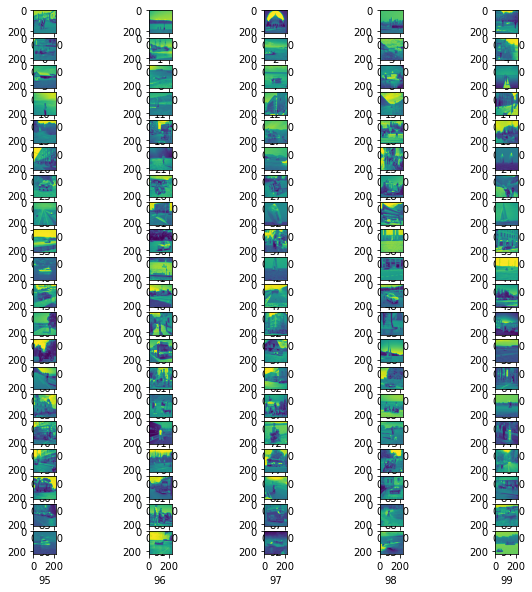

In [67]:
# Background class used back for sliding window, so when sliding window goes over regions of noninterest, it will know
background = {'filename':[], 'bndbox_img':[], 'objectType':[]}
backgroundDFdata = pd.DataFrame(data=background)

osDIR = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Background'
os.chdir(osDIR)
list = os.listdir()

for image in list:
    bb_img = plt.imread(image)
    bb_img = cv2.resize(bb_img, trainingSize) #img size change
    bb_img = color.rgb2gray(bb_img) ## COMMENT OR UNCOMMENT THIS
    background = {'filename':str(image), 'bndbox_img':bb_img, 'objectType':'Background'}
    backgroundDFdata = backgroundDFdata.append(background, ignore_index = True)
displayBNDBOXinDF(backgroundDFdata)

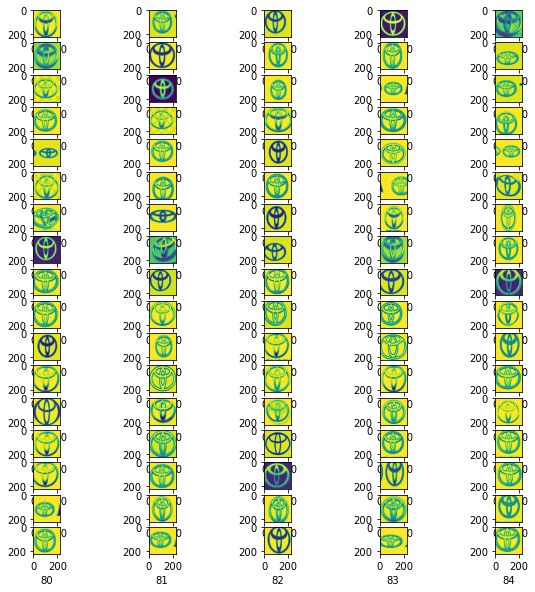

In [7]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Toyota"
ToyotaDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ToyotaDF)

In [8]:
ToyotaDF['objectType'].value_counts()

Toyota    86
Name: objectType, dtype: int64

In [9]:
#ToyotaDF.to_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\ToyotaDF.csv')

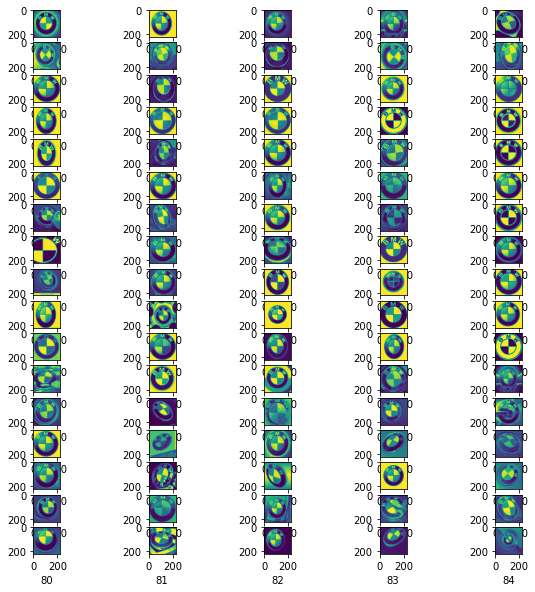

In [10]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\BMW"
BMWDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BMWDF)

In [11]:
BMWDF.to_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\BMWDF.csv')

In [12]:
BMWDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    86 non-null     object
 1   filepath    86 non-null     object
 2   size        86 non-null     object
 3   objectType  86 non-null     object
 4   bndbox      86 non-null     object
 5   bndbox_img  86 non-null     object
dtypes: object(6)
memory usage: 4.2+ KB


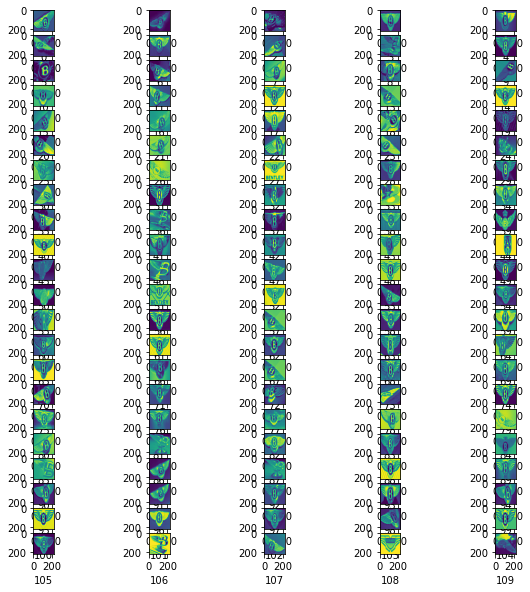

In [13]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Bentley"
BentleyDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BentleyDF)

In [14]:
BentleyDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    114 non-null    object
 1   filepath    114 non-null    object
 2   size        114 non-null    object
 3   objectType  114 non-null    object
 4   bndbox      114 non-null    object
 5   bndbox_img  114 non-null    object
dtypes: object(6)
memory usage: 5.5+ KB


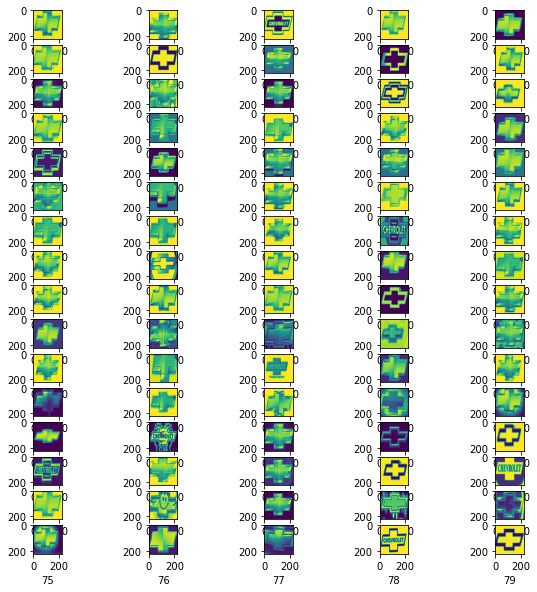

In [15]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Chevrolet"
ChevDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ChevDF)

In [16]:
ChevDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    80 non-null     object
 1   filepath    80 non-null     object
 2   size        80 non-null     object
 3   objectType  80 non-null     object
 4   bndbox      80 non-null     object
 5   bndbox_img  80 non-null     object
dtypes: object(6)
memory usage: 3.9+ KB


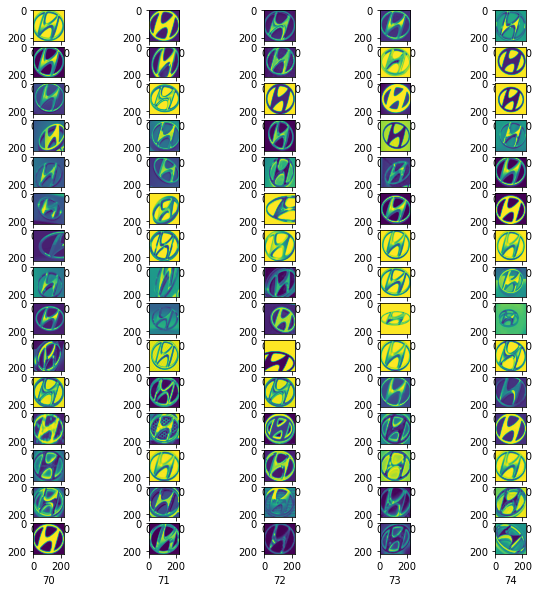

In [17]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Hyundai-1"
HyundaiDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(HyundaiDF)

In [18]:
HyundaiDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    79 non-null     object
 1   filepath    79 non-null     object
 2   size        79 non-null     object
 3   objectType  79 non-null     object
 4   bndbox      79 non-null     object
 5   bndbox_img  79 non-null     object
dtypes: object(6)
memory usage: 3.8+ KB


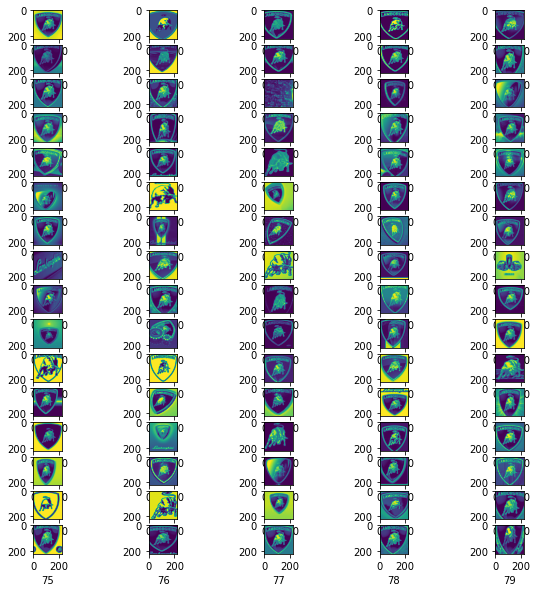

In [19]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Lamborghini"
LamborghiniDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(LamborghiniDF)

In [20]:
#LamborghiniDF.to_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\LamborghiniDF.csv')

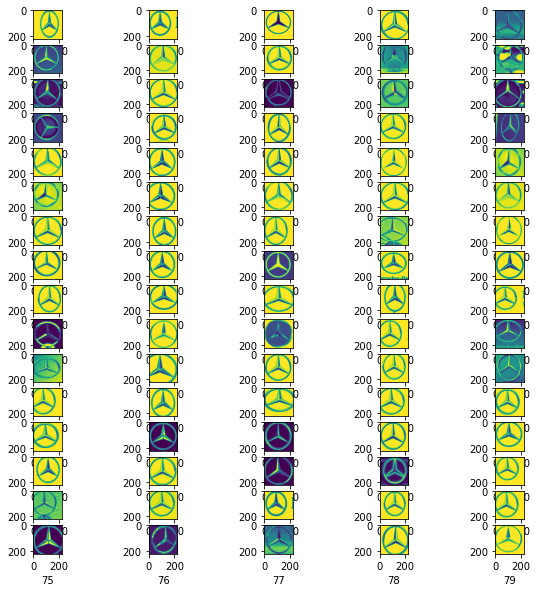

In [21]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Benz"
BenzDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BenzDF)

In [22]:
#BenzDF.to_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\BenzDF.csv')

C:\Users\alexa\AppData\Local\Temp/ipykernel_16552/3949949675.py:94: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(img) ## COMMENT OR UNCOMMENT THIS --------------------


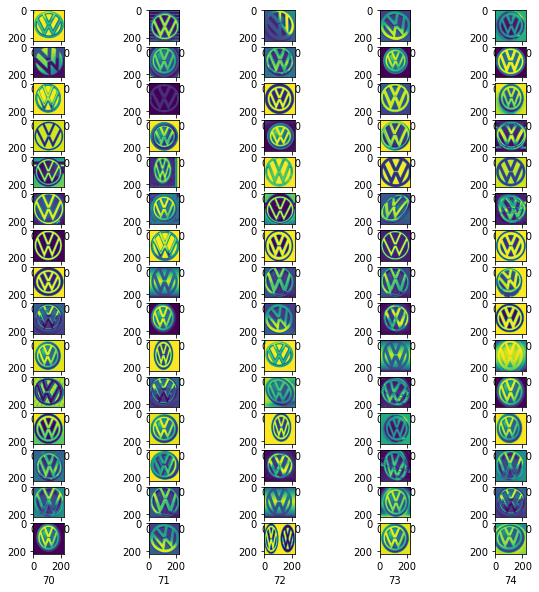

In [23]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Volkswagon"
VolkswagonDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(VolkswagonDF)

## Reading Logos From Car Logo Regions

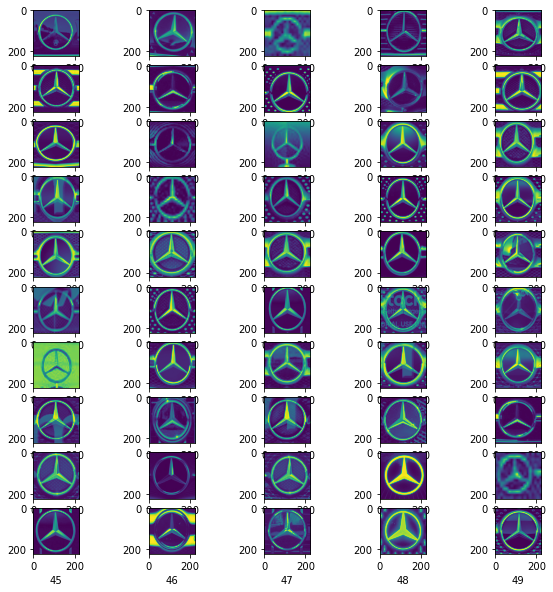

In [24]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Benz"
BenzRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BenzRegionDF)

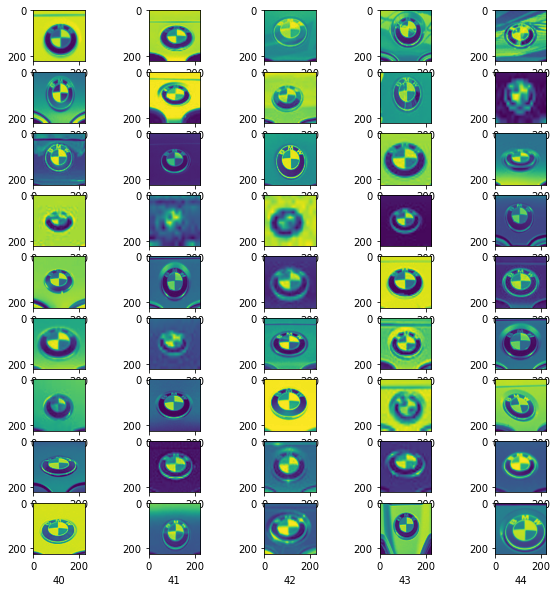

In [25]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\BMW"
BMWRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BMWRegionDF)

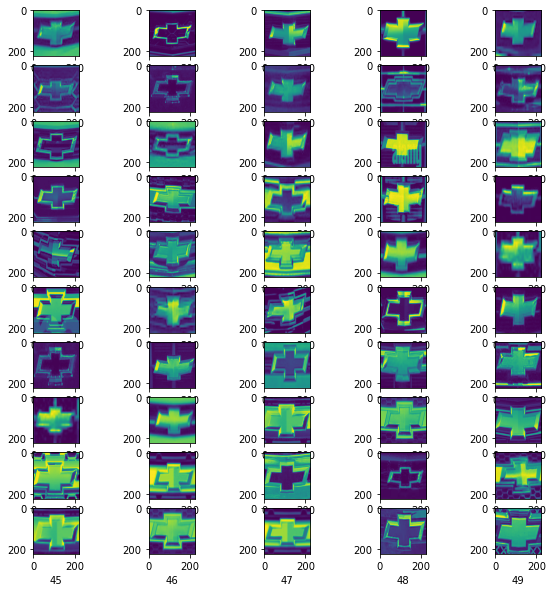

In [26]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Chevrolet"
ChevroletRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ChevroletRegionDF)

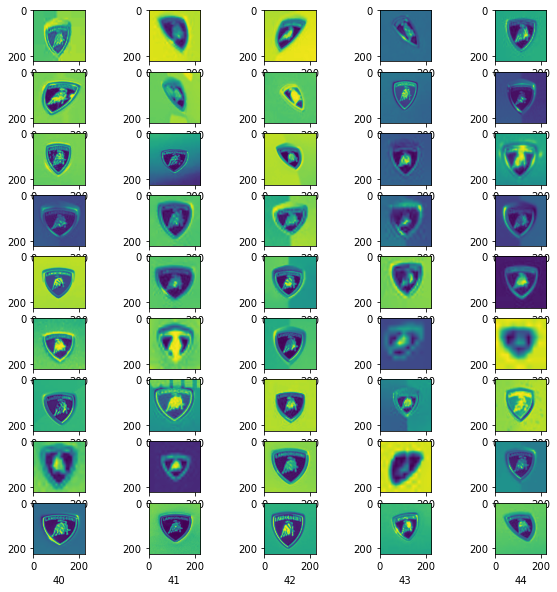

In [27]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Lamborghini"
LamborghiniRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(LamborghiniRegionDF)

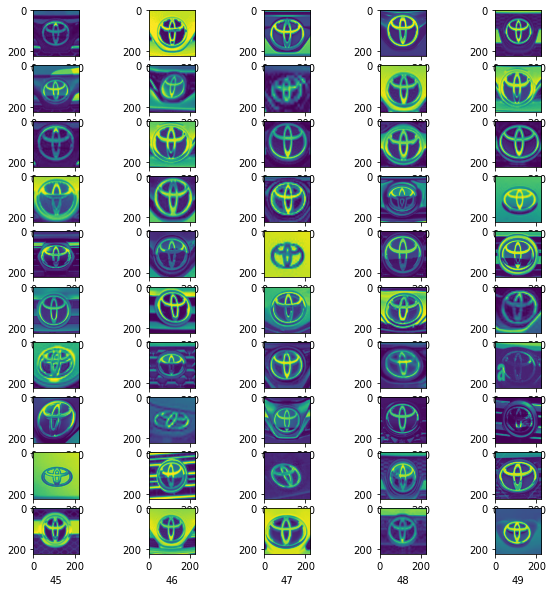

In [28]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Toyota"
ToyotaRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ToyotaRegionDF)

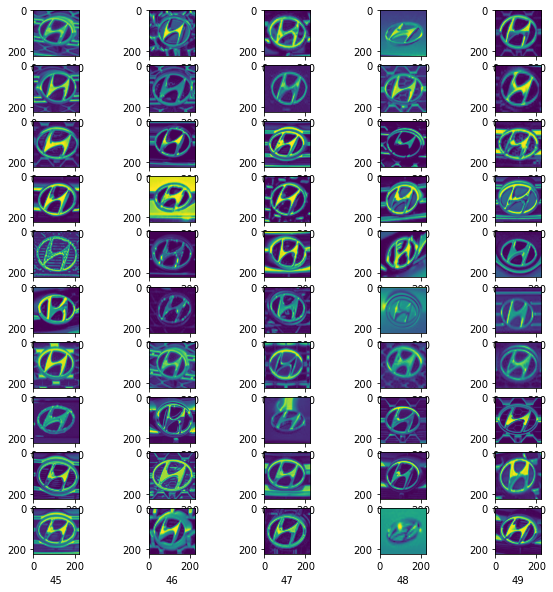

In [29]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Hyundai"
HyundaiRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(HyundaiRegionDF)

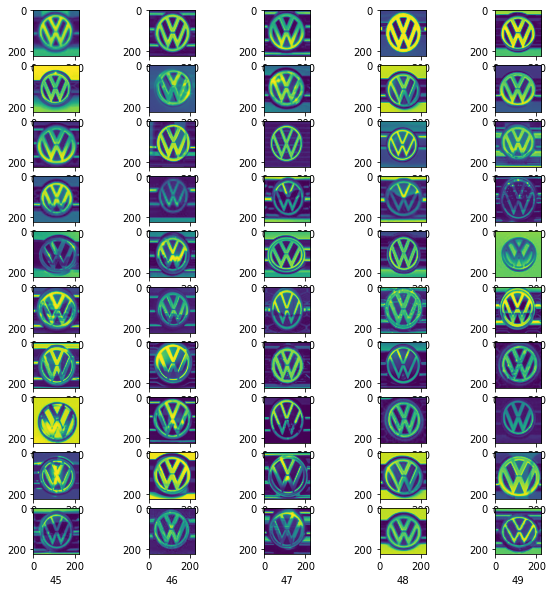

In [30]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Volkswagon"
VolkswagonRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(VolkswagonRegionDF)

# Combining Logos

In [31]:
BenzDFdata = BenzDF[['filename', 'bndbox_img', 'objectType']]
ChevDFdata = ChevDF[['filename', 'bndbox_img', 'objectType']]
#BentleyDFdata = BentleyDF[['filename', 'bndbox_img', 'objectType']]
BMWDFdata = BMWDF[['filename', 'bndbox_img', 'objectType']]
LamborghiniDFdata = LamborghiniDF[['filename', 'bndbox_img', 'objectType']]
HyundaiDFdata = HyundaiDF[['filename', 'bndbox_img', 'objectType']]
ToyotaDFdata = ToyotaDF[['filename', 'bndbox_img', 'objectType']]
VolkswagonDFdata = VolkswagonDF[['filename', 'bndbox_img', 'objectType']]

In [32]:
BenzRegionDFdata = BenzRegionDF[['filename', 'bndbox_img', 'objectType']]
ChevRegionDFdata = ChevroletRegionDF[['filename', 'bndbox_img', 'objectType']]
BMWRegionDFdata = BMWRegionDF[['filename', 'bndbox_img', 'objectType']]
LamborghiniRegionDFdata = LamborghiniRegionDF[['filename', 'bndbox_img', 'objectType']]
ToyotaRegionDFdata = ToyotaRegionDF[['filename', 'bndbox_img', 'objectType']]
HyundaiRegionDFdata = HyundaiRegionDF[['filename', 'bndbox_img', 'objectType']]
VolkswagonRegionDFdata = VolkswagonRegionDF[['filename', 'bndbox_img', 'objectType']]

In [61]:
combinedDF = pd.concat([BenzDFdata, BenzRegionDFdata, 
                        ChevDFdata, ChevRegionDFdata,
                        VolkswagonDFdata, VolkswagonRegionDFdata,
                        ToyotaDFdata, ToyotaRegionDFdata])
# BMWDFdata,BMWRegionDFdata,

In [62]:
combinedDF['objectType'].value_counts()

Toyota        136
Mercedes      135
Volkswagen    133
Chevrolet     132
Name: objectType, dtype: int64

In [63]:
from sklearn.preprocessing import LabelEncoder

In [64]:
le = LabelEncoder()
combinedDF['label'] = le.fit_transform(combinedDF.objectType)

In [65]:
combinedDF['label'].value_counts()

2    136
1    135
3    133
0    132
Name: label, dtype: int64

In [39]:
train_images = np.stack(combinedDF.bndbox_img.values,axis=0)
print(train_images.shape)

(928, 224, 224)


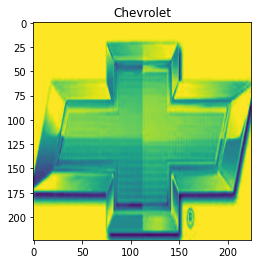

In [40]:
random_sample = np.random.randint(0,928)
plt.imshow(train_images[random_sample])
plt.title(combinedDF.objectType.iloc[random_sample])
plt.show()

In [66]:
combinedDF.head()

filename  \
0  <xml.etree.ElementTree.ElementTree object at 0...   
1  <xml.etree.ElementTree.ElementTree object at 0...   
2  <xml.etree.ElementTree.ElementTree object at 0...   
3  <xml.etree.ElementTree.ElementTree object at 0...   
4  <xml.etree.ElementTree.ElementTree object at 0...   

                                          bndbox_img objectType  label  
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   Mercedes      1  
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   Mercedes      1  
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   Mercedes      1  
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   Mercedes      1  
4  [[0.3215686274509804, 0.3215686274509804, 0.32...   Mercedes      1

In [41]:
combinedDF.to_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\ALLcombinedDFwRegion.csv')

In [42]:
combinedDFwRegion = pd.read_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\ALLcombinedDFwRegion.csv')

In [43]:
combinedDFwRegion['objectType'].value_counts()

Toyota         136
Mercedes       135
BMW            133
Volkswagen     133
Chevrolet      132
Hyundai        130
Lamborghini    129
Name: objectType, dtype: int64

## Extracting HOG Features

In [44]:
from skimage.feature import hog

In [45]:
# HOG
hog_images = []
hog_features = []
counter = 0
for i in train_images:
    #if counter % 10 == 0:
        #print(counter)
    fd, hog_image = hog(i, orientations=9, 
                        pixels_per_cell=(8,8),cells_per_block=(2,2), 
                        block_norm= 'L2', visualize=True)
    
    hog_images.append(hog_image)
    hog_features.append(fd)
    counter += 1
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)
print(hog_features.shape)
print(hog_images.shape)

(928, 26244)
(928, 224, 224)


In [46]:
from sklearn.model_selection import train_test_split

In [47]:
y = combinedDF['label']
y.value_counts()

5    136
4    135
0    133
6    133
1    132
2    130
3    129
Name: label, dtype: int64

In [48]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)

## HOG

In [98]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, y, 
                                                    stratify=combinedDF.label, 
                                                    test_size=.2,shuffle=True)
print(X_train.shape)
print(X_test.shape)

(590, 26244)
(148, 26244)


In [99]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)
from sklearn.linear_model import SGDClassifier

In [74]:
# Training
svm = SGDClassifier() #LinearSVM()  ## Linear SVM works reliably, but SGD when lucky, can do almost perfect. However, loading
# with same parameters doesn't result in same model
svm.fit(X_train, y_train)
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)    # Testing

In [75]:
print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test))
print(confusion_matrix(y_pred_test, y_test))
confusion_matrix(y_pred_train, y_train)

Accuracy_test : 0.9848 Precision_test : 0.9857 Recall_test : 0.9849 F1-Score : 0.9849

classification report testing : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.96      0.98        26
           2       0.93      1.00      0.96        26
           3       1.00      0.96      0.98        27
           4       1.00      1.00      1.00        26

    accuracy                           0.98       132
   macro avg       0.99      0.98      0.98       132
weighted avg       0.99      0.98      0.98       132

[[27  0  0  0  0]
 [ 0 25  0  0  0]
 [ 0  1 26  1  0]
 [ 0  0  0 26  0]
 [ 0  0  0  0 26]]


array([[106,   0,   0,   0,   0],
       [  0, 105,   0,   0,   0],
       [  0,   0, 103,   0,   0],
       [  0,   0,   0, 108,   0],
       [  0,   0,   0,   0, 105]], dtype=int64)

In [76]:
import pickle
filename = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\sgdCwRegion.sav'
pickle.dump(svm, open(filename, 'wb'))

### HOG Testing below

[0]


0

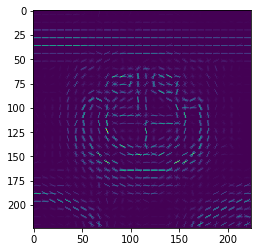

In [69]:
value = 249
plt.imshow(hog_images[value])
print(svm.predict([hog_features[value]]))
combinedDF['label'].iloc[value]

['BMW']
[[ 152.23528278 -604.85823384 -351.53677659 -637.02820367 -519.20499524]]
0
152.23528278048795


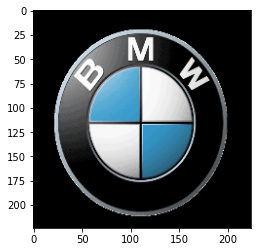

In [70]:
path = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Outdated Dataset\Dataset\bmw_2.jpg'
testImage(path)

## HOG Images + CNN

In [49]:
y.value_counts()

5    136
4    135
0    133
6    133
1    132
2    130
3    129
Name: label, dtype: int64

In [50]:
X_train_images, X_test_images, y_train_images, y_test_images = train_test_split(hog_images, y, 
                                                    stratify=combinedDF.label, 
                                                    test_size=.3,shuffle=True)
print(X_train_images.shape)
print(X_test_images.shape)

(649, 224, 224)
(279, 224, 224)


In [51]:
from tensorflow.keras import layers, models

In [56]:
cnn = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=(3,), activation='relu', input_shape=trainingSize),
    layers.MaxPooling1D((2,)),
    
    layers.Conv1D(filters=64, kernel_size=(3,), activation='relu'),
    layers.MaxPooling1D((2,)),
    
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(7, activation='softmax')
])
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
cnn.fit(X_train_images, y_train_images, validation_data=(X_test_images, y_test_images), epochs=10)

Epoch 1/10
21/21 [==============================] - 1s 25ms/step - loss: 1.6593 - accuracy: 0.4253 - val_loss: 1.0786 - val_accuracy: 0.7312
Epoch 2/10
21/21 [==============================] - 0s 15ms/step - loss: 0.6423 - accuracy: 0.8382 - val_loss: 0.4432 - val_accuracy: 0.8530
Epoch 3/10
21/21 [==============================] - 0s 10ms/step - loss: 0.3353 - accuracy: 0.9137 - val_loss: 0.2437 - val_accuracy: 0.9534
Epoch 4/10
21/21 [==============================] - 0s 10ms/step - loss: 0.1798 - accuracy: 0.9599 - val_loss: 0.1865 - val_accuracy: 0.9462
Epoch 5/10
21/21 [==============================] - 0s 10ms/step - loss: 0.1040 - accuracy: 0.9846 - val_loss: 0.1428 - val_accuracy: 0.9642
Epoch 6/10
21/21 [==============================] - 0s 10ms/step - loss: 0.0641 - accuracy: 0.9861 - val_loss: 0.1486 - val_accuracy: 0.9570
Epoch 7/10
21/21 [==============================] - 0s 9ms/step - loss: 0.0433 - accuracy: 0.9954 - val_loss: 0.1521 - val_accuracy: 0.9642
Epoch 8/10
21/

In [57]:
import tensorflow as tf

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
y_pred = cnn.predict(X_test_images)
y_pred_classes = [np.argmax(element) for element in y_pred] #predicts all to proper

print("Classification Report: \n", classification_report(y_test_images, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      1.00      1.00        40
           2       0.90      0.97      0.94        39
           3       0.97      0.87      0.92        39
           4       1.00      1.00      1.00        40
           5       1.00      0.95      0.97        41
           6       1.00      1.00      1.00        40

    accuracy                           0.97       279
   macro avg       0.97      0.97      0.97       279
weighted avg       0.97      0.97      0.97       279



In [59]:
cnn.save(r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\ALLcnnHOGwRegion")

INFO:tensorflow:Assets written to: G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\ALLcnnHOGwRegion\assets


0


0

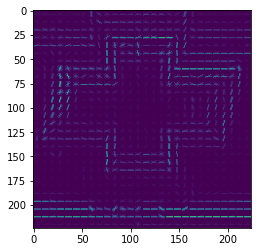

In [61]:
plt.imshow(hog_images[249])
print(np.argmax(cnn.predict(np.array([hog_images[249],]))))
combinedDF['label'].iloc[249]

## Sliding Window Implementation and Testing - FAILURE

In [ ]:
#Tested on classes: 0 - Toyota   1 - Background  2 - Bentley  3 - Chevrolet 4 - Hyundai 5 - Lambo   6 - Mercedes 7 - BMW

['Background']
[[-101.74889117   70.53449339 -202.22759161 -140.84138913 -235.63285979
  -280.19259342]]
1
70.53449338772393


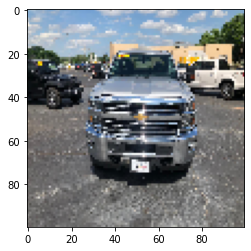

In [65]:
path = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Outdated Dataset\Dataset\chevroletF_2.jpg'
#path = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Outdated Dataset\Dataset\testChev.jpg'
#path = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Outdated Dataset\Dataset\hyundaiF_1.jpg'
#path = r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Outdated Dataset\Dataset\toyotaF_1.jpg'
#testImageCNN(path)
testImage(path)

In [66]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0]-windowSize[1], stepSize):
        for x in range(0, image.shape[1]-windowSize[0], stepSize):
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [67]:
def image_pyramid(image, scale, minSize):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w) 
        
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

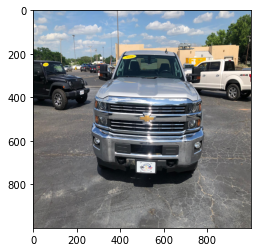

In [68]:
img = plt.imread(path)
img = cv2.resize(img, (1000, 1000))
plt.imshow(img)

In [267]:
for (i, resized) in enumerate(image_pyramid(img, scale=1.5, minSize=trainingSize)):
    # show the resized image
    cv2.imshow("Layer {}".format(i + 1), resized)
    cv2.waitKey(0)
cv2.destroyAllWindows()

## CNN IMPLEMENTATION

In [211]:
start = time.time()
detections = []
for p, image in enumerate(image_pyramid(img, scale=1.5, minSize=trainingSize)):
    print(p)
    #print(detections)
    scale = img.shape[1] / float(image.shape[1])
    for (x, y, window) in sliding_window(image, 20, trainingSize):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(trainingSize[0] * scale)
        h = int(trainingSize[1] * scale)
        
        window = color.rgb2gray(window)
        fd, hog_image = hog(window, orientations=9, 
                        pixels_per_cell=(8,8),cells_per_block=(2,2), 
                        block_norm= 'L2', visualize=True)
        fd = fd.reshape(1, -1)
        probabilities = cnn.predict(np.array([hog_image,]))
        pred = np.argmax(cnn.predict(np.array([hog_image,])))
        
        
        #svm.decision_function(fd)
        # 0 - Toyota   1 - Background  2 - Bentley  3 - Chevrolet 4 - Hyundai 5 - Lambo   6 - Mercedes 7 - BMW
        #[[-0.88050786  0.81478658    -1.36759824   -1.81740073   -1.53630982 -1.86367815 -2.10756407  -1.89924436]]
        
        
        #print((pred, probabilities, int(x), int(y), int(w), int(h), probabilities[0][pred]))
        if (pred != le.transform(['Background'])[0]):
            if probabilities[0][pred] > 0.7:
                print((pred, probabilities, int(x), int(y), int(w), int(h), probabilities[0][pred]))
                print(" ")
                detections.append(
                    (pred, probabilities,
                    int(x), int(y), int(w), int(h)) #roi
                )
        # clone the original image and then draw a bounding box
        # surrounding the current region
        
#         clone = img.copy()
#         cv2.rectangle(img=clone, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=5)
#         cv2.imshow('le.inverse_transform(svm.predict([fd]))[0]', clone)
#         cv2.waitKey(1)
#         time.sleep(0.025)
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))

                           
clone = img.copy()
for (_, _, x_tl, y_tl, w, h) in detections:
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (_, _, x, y, w, h) in detections])                                             
## print(svm.decision_function([fd])[0][np.argmax(svm.decision_function([fd])[0])]) 
sc = [probabilities[0][position] for (position, probabilities, x, y, w, h) in detections]
#scp = [(probabilities[0][position], le.transform(position)) for (position, probabilities, x, y, w, h) in detections]      
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)


                           
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(clone, (xA, yA), (xB, yB), (0,255,0), 2)
cv2.imshow("Result", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

0
(2, array([[7.4832030e-02, 1.3627782e-01, 7.5818831e-01, 2.8011024e-02,
        3.1347334e-04, 2.3763748e-03, 2.1354984e-07, 8.6607122e-07]],
      dtype=float32), 0, 160, 100, 100, 0.7581883)
 
(2, array([[2.9236978e-02, 1.0930780e-01, 7.1720099e-01, 1.3798633e-01,
        5.6238184e-03, 6.3713174e-04, 1.9084162e-06, 5.0300928e-06]],
      dtype=float32), 720, 160, 100, 100, 0.717201)
 
(2, array([[3.1722537e-03, 1.6456982e-02, 9.1734457e-01, 6.2665179e-02,
        2.3178433e-04, 1.2851905e-04, 1.7843672e-07, 6.4028814e-07]],
      dtype=float32), 780, 160, 100, 100, 0.91734457)
 
(2, array([[1.8050582e-03, 5.1809871e-03, 9.7934514e-01, 1.3423190e-02,
        1.2477656e-04, 1.1969538e-04, 2.4257946e-07, 8.7305915e-07]],
      dtype=float32), 800, 160, 100, 100, 0.97934514)
 
(2, array([[1.2278638e-03, 1.9188190e-02, 9.3930238e-01, 3.9691970e-02,
        5.2037073e-04, 6.7253088e-05, 4.7599659e-07, 1.6058743e-06]],
      dtype=float32), 820, 160, 100, 100, 0.9393024)
 
(2, array([[7.

(2, array([[2.0020675e-02, 1.5002984e-01, 8.1165975e-01, 6.4701955e-03,
        3.1802952e-04, 1.1233210e-02, 7.5976386e-05, 1.9238851e-04]],
      dtype=float32), 440, 280, 100, 100, 0.81165975)
 
(2, array([[5.1357192e-03, 4.5138039e-02, 9.4330800e-01, 1.4952426e-03,
        3.1735228e-05, 4.8548817e-03, 8.6069922e-06, 2.7738835e-05]],
      dtype=float32), 460, 280, 100, 100, 0.943308)
 
(2, array([[5.7583493e-03, 9.3078032e-02, 8.8046300e-01, 6.4861393e-03,
        4.1029958e-05, 1.4087764e-02, 1.8259689e-05, 6.7375266e-05]],
      dtype=float32), 480, 280, 100, 100, 0.880463)
 
(2, array([[4.3360256e-03, 9.9728204e-02, 8.7867516e-01, 3.7254642e-03,
        3.1248364e-05, 1.3443158e-02, 1.2416991e-05, 4.8257749e-05]],
      dtype=float32), 500, 280, 100, 100, 0.87867516)
 
(2, array([[4.4327090e-03, 8.8999294e-02, 8.9800811e-01, 1.0753450e-03,
        4.6352096e-05, 7.3992042e-03, 8.7872904e-06, 3.0259873e-05]],
      dtype=float32), 520, 280, 100, 100, 0.8980081)
 
(2, array([[5.9

(2, array([[1.4684801e-02, 2.4181597e-01, 7.4273604e-01, 7.0982351e-04,
        3.2219839e-06, 5.0052749e-05, 1.1114315e-10, 1.1996195e-09]],
      dtype=float32), 660, 380, 100, 100, 0.74273604)
 
(2, array([[3.3464413e-08, 9.8412946e-02, 9.0157819e-01, 8.7892977e-06,
        2.6273219e-09, 1.9908825e-08, 5.0711312e-16, 3.3890745e-15]],
      dtype=float32), 440, 400, 100, 100, 0.9015782)
 
(2, array([[1.9860595e-06, 1.5800843e-01, 8.4191519e-01, 7.4320436e-05,
        2.6364360e-08, 2.4838638e-09, 3.3101060e-16, 5.6597975e-15]],
      dtype=float32), 480, 400, 100, 100, 0.8419152)
 
(2, array([[2.5364210e-07, 7.7167009e-03, 9.9223220e-01, 5.0871848e-05,
        2.8916325e-09, 1.8536405e-09, 3.0285856e-16, 5.6398715e-15]],
      dtype=float32), 500, 400, 100, 100, 0.9922322)
 
(2, array([[4.4134099e-06, 7.2002909e-03, 9.9270248e-01, 9.2797272e-05,
        2.3434923e-08, 1.6711384e-09, 4.5065620e-16, 7.0847928e-15]],
      dtype=float32), 520, 400, 100, 100, 0.9927025)
 
(2, array([[8.

(2, array([[1.9067999e-02, 6.6419177e-02, 8.9287871e-01, 2.1608880e-02,
        2.4663010e-05, 5.7784746e-07, 1.5142772e-10, 1.5526737e-09]],
      dtype=float32), 660, 460, 100, 100, 0.8928787)
 
(2, array([[2.3781551e-05, 2.4703104e-02, 9.7525841e-01, 1.4732443e-05,
        1.6592466e-10, 1.9132240e-09, 2.6561959e-18, 8.6254536e-17]],
      dtype=float32), 340, 500, 100, 100, 0.9752584)
 
(2, array([[7.9166339e-06, 1.6741216e-02, 9.8325068e-01, 2.4625939e-07,
        9.3554179e-13, 2.8597057e-11, 1.4719257e-20, 1.0882082e-18]],
      dtype=float32), 360, 500, 100, 100, 0.9832507)
 
(2, array([[7.7982651e-05, 1.1305177e-01, 8.8686663e-01, 3.6392642e-06,
        9.9280801e-12, 6.0877942e-10, 7.0280310e-19, 4.6981953e-17]],
      dtype=float32), 380, 500, 100, 100, 0.8868666)
 
(2, array([[3.2125215e-06, 1.3583708e-02, 9.8641300e-01, 9.8647540e-08,
        8.6295126e-13, 1.6735960e-10, 7.9666243e-20, 3.7598556e-18]],
      dtype=float32), 400, 500, 100, 100, 0.986413)
 
(2, array([[1.18

(2, array([[8.5593133e-10, 3.8051084e-04, 9.9961948e-01, 3.1963296e-08,
        8.2728327e-15, 1.5734859e-08, 1.1364079e-17, 4.6115539e-16]],
      dtype=float32), 580, 560, 100, 100, 0.9996195)
 
(2, array([[1.1649079e-08, 7.8977086e-03, 9.9210161e-01, 3.3225626e-07,
        1.2720107e-13, 3.4201037e-07, 3.3373905e-16, 1.4429962e-14]],
      dtype=float32), 600, 560, 100, 100, 0.9921016)
 
(2, array([[3.00809717e-07, 7.61515573e-02, 9.23825920e-01, 9.86469058e-06,
        1.22087705e-11, 1.23671243e-05, 6.18559837e-14, 1.75201303e-12]],
      dtype=float32), 620, 560, 100, 100, 0.9238259)
 
(3, array([[1.0206192e-02, 4.5841593e-02, 1.5703885e-01, 7.8147095e-01,
        5.1160627e-03, 3.0210876e-04, 5.3187828e-06, 1.8911524e-05]],
      dtype=float32), 300, 580, 100, 100, 0.78147095)
 
(3, array([[2.6747759e-03, 6.1366437e-03, 2.4540618e-01, 7.4549383e-01,
        2.7548228e-04, 1.2733512e-05, 6.3277220e-08, 2.5354447e-07]],
      dtype=float32), 320, 580, 100, 100, 0.7454938)
 
(2, ar

(2, array([[3.3830296e-05, 1.1728804e-03, 9.9693131e-01, 1.8459226e-03,
        9.1685180e-08, 1.5998874e-05, 2.8552516e-10, 1.6353394e-09]],
      dtype=float32), 520, 660, 100, 100, 0.9969313)
 
(2, array([[4.6322600e-04, 2.2914878e-03, 8.5926127e-01, 1.3796711e-01,
        7.5149032e-06, 9.1969732e-06, 3.3057233e-08, 1.3108072e-07]],
      dtype=float32), 540, 660, 100, 100, 0.8592613)
 
(2, array([[4.7786706e-04, 1.7217895e-03, 9.0934080e-01, 8.8438690e-02,
        1.3470756e-05, 6.8443974e-06, 1.1044101e-07, 3.6984480e-07]],
      dtype=float32), 560, 660, 100, 100, 0.9093408)
 
(2, array([[4.4022612e-03, 8.6815432e-03, 8.2305878e-01, 1.6366550e-01,
        1.3215130e-04, 5.4647855e-05, 1.3847764e-06, 3.7048080e-06]],
      dtype=float32), 580, 660, 100, 100, 0.8230588)
 
(2, array([[2.3518209e-04, 1.7061850e-02, 9.3770313e-01, 4.4988550e-02,
        4.8704560e-06, 6.3008547e-06, 5.2611004e-09, 2.7471925e-08]],
      dtype=float32), 500, 680, 100, 100, 0.93770313)
 
(2, array([[3.

(2, array([[8.0182758e-04, 2.6785433e-02, 9.6656680e-01, 5.5883327e-03,
        2.5729823e-04, 3.5167906e-07, 4.1195003e-09, 1.7244227e-08]],
      dtype=float32), 510, 300, 150, 150, 0.9665668)
 
(2, array([[1.1392510e-03, 7.7968106e-02, 9.1588378e-01, 4.8427819e-03,
        1.6566458e-04, 3.9278675e-07, 3.5569012e-09, 1.9132321e-08]],
      dtype=float32), 540, 300, 150, 150, 0.9158838)
 
(2, array([[1.8705316e-03, 2.7683344e-02, 9.6844852e-01, 1.8998035e-03,
        9.7319513e-05, 4.9625140e-07, 2.1093940e-09, 1.1277886e-08]],
      dtype=float32), 570, 300, 150, 150, 0.9684485)
 
(2, array([[3.0635679e-02, 5.7427220e-02, 9.0318644e-01, 8.6185234e-03,
        1.2656556e-04, 5.4347274e-06, 6.7505033e-09, 5.0042324e-08]],
      dtype=float32), 600, 300, 150, 150, 0.90318644)
 
(2, array([[3.3237075e-03, 6.8352565e-02, 9.2173237e-01, 6.5775025e-03,
        6.8472605e-06, 6.9930129e-06, 1.3874226e-09, 1.2149541e-08]],
      dtype=float32), 630, 300, 150, 150, 0.92173237)
 
(2, array([[4

(2, array([[6.6604262e-04, 1.4561477e-01, 8.4873712e-01, 4.9793120e-03,
        2.6975765e-06, 9.0609369e-09, 4.3444507e-13, 3.9017921e-12]],
      dtype=float32), 630, 450, 150, 150, 0.8487371)
 
(2, array([[4.0534736e-09, 1.5020058e-01, 8.4979910e-01, 2.8388601e-07,
        2.4849341e-12, 1.5373494e-08, 1.0159700e-17, 2.3756400e-16]],
      dtype=float32), 330, 480, 150, 150, 0.8497991)
 
(2, array([[5.9233579e-10, 1.8822604e-01, 8.1177396e-01, 1.2299326e-08,
        1.4281481e-13, 2.3928057e-10, 7.6733138e-20, 3.0922114e-18]],
      dtype=float32), 360, 480, 150, 150, 0.81177396)
 
(2, array([[1.5129608e-08, 3.8937867e-02, 9.6106213e-01, 2.5813993e-09,
        2.3384647e-13, 1.4063865e-10, 6.0673691e-20, 3.6723639e-18]],
      dtype=float32), 390, 480, 150, 150, 0.96106213)
 
(2, array([[2.3955209e-07, 1.0000916e-01, 8.9999062e-01, 3.8048018e-08,
        4.7862192e-12, 1.3243852e-09, 2.0552450e-18, 1.3263598e-16]],
      dtype=float32), 420, 480, 150, 150, 0.8999906)
 
(2, array([[2

(2, array([[2.2377379e-04, 4.5428883e-02, 9.5362437e-01, 4.9129518e-04,
        2.6673931e-08, 2.3168573e-04, 8.9802260e-10, 7.8456743e-09]],
      dtype=float32), 390, 630, 150, 150, 0.95362437)
 
(2, array([[2.1505615e-05, 7.6869912e-02, 9.1325116e-01, 1.2882718e-05,
        1.0570276e-09, 9.8446496e-03, 7.7122225e-11, 1.6002599e-09]],
      dtype=float32), 480, 630, 150, 150, 0.91325116)
 
(2, array([[2.1129210e-05, 3.6528289e-02, 9.6284711e-01, 7.6139069e-05,
        6.5433161e-09, 5.2740215e-04, 2.7444419e-10, 3.6979997e-09]],
      dtype=float32), 510, 630, 150, 150, 0.9628471)
 
(2, array([[1.9734383e-04, 1.5857190e-02, 9.8224980e-01, 2.9660639e-04,
        8.0741771e-08, 1.3988405e-03, 1.8612040e-08, 1.4813030e-07]],
      dtype=float32), 540, 630, 150, 150, 0.9822498)
 
(2, array([[1.2368176e-03, 9.8840639e-02, 8.9459372e-01, 3.0087677e-03,
        1.0372565e-05, 2.3053838e-03, 7.6825665e-07, 3.5193705e-06]],
      dtype=float32), 570, 630, 150, 150, 0.8945937)
 
(3, array([[7

(2, array([[1.4021210e-05, 2.9923543e-04, 9.6980536e-01, 2.9881340e-02,
        3.0815464e-08, 4.0886992e-11, 1.1948770e-13, 1.4198835e-12]],
      dtype=float32), 495, 540, 225, 225, 0.96980536)
 
(2, array([[6.5747899e-06, 1.4667906e-04, 9.8481488e-01, 1.5031936e-02,
        5.0022653e-08, 5.6358646e-10, 2.4156176e-12, 1.4789409e-11]],
      dtype=float32), 540, 540, 225, 225, 0.9848149)
 
(2, array([[8.2894236e-05, 1.3678808e-03, 9.8960447e-01, 8.9433920e-03,
        1.0643698e-06, 1.7435215e-07, 1.4591116e-10, 7.2965051e-10]],
      dtype=float32), 585, 540, 225, 225, 0.9896045)
 
(2, array([[2.9245118e-02, 2.8679959e-02, 9.0226400e-01, 3.9785478e-02,
        1.0273214e-05, 1.5102750e-05, 3.0503923e-08, 8.8180215e-08]],
      dtype=float32), 450, 630, 225, 225, 0.902264)
 
(2, array([[2.0733243e-02, 7.5461470e-02, 8.6391485e-01, 3.9787501e-02,
        1.5551821e-05, 8.6741020e-05, 1.4818212e-07, 5.2432415e-07]],
      dtype=float32), 495, 630, 225, 225, 0.86391485)
 
(2, array([[9.

## SVM IMPLEMENTATION

In [77]:
start = time.time()
detections = []
for p, image in enumerate(image_pyramid(img, scale=1.5, minSize=trainingSize)):
    scale = img.shape[1] / float(image.shape[1])
    for (x, y, window) in sliding_window(image, 20, trainingSize):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(trainingSize[0] * scale)
        h = int(trainingSize[1] * scale)
        
        window = color.rgb2gray(window)
        fd, hog_image = hog(window, orientations=9, 
                        pixels_per_cell=(8,8),cells_per_block=(2,2), 
                        block_norm= 'L2', visualize=True)
        fd = fd.reshape(1, -1)
        pred = svm.predict(fd)
        
        
        
        #svm.decision_function(fd)
        # 0 - Toyota   1 - Background  2 - Bentley  3 - Chevrolet 4 - Hyundai 5 - Lambo   6 - Mercedes 7 - BMW
        #[[-0.88050786  0.81478658    -1.36759824   -1.81740073   -1.53630982 -1.86367815 -2.10756407  -1.89924436]]
        
        
        
        if (pred != le.transform(['Background'])[0]):
            position = int(np.argmax(svm.decision_function(fd)))
            probabilities = svm.decision_function(fd)
            if probabilities[0][position] > 75:
                print(le.inverse_transform(svm.predict(fd))[0], position, probabilities, x, y, w, h)
                detections.append(
                    (position, probabilities,
                    int(x), int(y), int(w), int(h)) #roi
                )
#                 cv2.imshow('window', window)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
                
        # clone the original image and then draw a bounding box
        # surrounding the current region
        
#         clone = img.copy()
#         cv2.rectangle(img=clone, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=5)
#         cv2.imshow('le.inverse_transform(svm.predict([fd]))[0]', clone)
#         cv2.waitKey(1)
#         time.sleep(0.025)
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))

                           
clone = img.copy()
for (_, _, x_tl, y_tl, w, h) in detections:
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (_, _, x, y, w, h) in detections])                                             
## print(svm.decision_function([fd])[0][np.argmax(svm.decision_function([fd])[0])]) 
sc = [probabilities[0][position] for (position, probabilities, x, y, w, h) in detections]    
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)


                           
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(clone, (xA, yA), (xB, yB), (0,255,0), 2)
cv2.imshow("Result", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

Chevrolet 2 [[-220.37293274 -128.1013863    94.24380487 -110.2791158  -166.68327877
   -30.72700699]] 400 200 100 100
Chevrolet 2 [[-149.62614038   69.53739003  118.02220596 -157.84591163 -192.5326853
   -91.11860696]] 700 220 100 100
Chevrolet 2 [[-189.72306025  -15.01373644  102.71220728  -92.54028985 -116.56313335
  -131.81506658]] 800 220 100 100
Chevrolet 2 [[ -27.17722815  -64.05025331   80.59888065 -264.69281475  -75.27861882
  -207.46641736]] 380 240 100 100
Chevrolet 2 [[-155.44384989  -21.26597318   87.70109878 -123.08420899 -181.53229629
  -191.82905834]] 560 320 100 100
Chevrolet 2 [[-165.61351891   -6.71713184   75.73019168  -69.61617594 -177.92133241
  -178.65033114]] 540 380 100 100
Chevrolet 2 [[-137.58895306  -11.82577408   95.58890242  -75.0244997  -187.8679794
  -180.9937152 ]] 580 380 100 100
Chevrolet 2 [[-151.61378124    5.6271177    95.36030178  -85.02267444 -175.58399841
  -181.5981759 ]] 600 380 100 100
Chevrolet 2 [[ -95.97775175  -17.16592772   84.53051412  -

In [80]:
clone = img.copy()
for (_, _, x_tl, y_tl, w, h) in detections:
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (_, _, x, y, w, h) in detections])                                             
## print(svm.decision_function([fd])[0][np.argmax(svm.decision_function([fd])[0])]) 
sc = [probabilities[0][position] for (position, probabilities, x, y, w, h) in detections]    
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.4)


                           
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(clone, (xA, yA), (xB, yB), (0,255,0), 2)
cv2.imshow("Raw Detections after NMS", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

detection confidence score:  [94.24380486883031, 118.0222059591367, 102.71220728418763, 80.59888064992965, 87.70109878487109, 75.73019167831667, 95.58890242345723, 95.36030177852209, 84.53051412437247, 75.09806484005162, 85.2681690686748, 76.63013412426798, 86.18761759984488, 89.52240188579063, 95.65175019483635, 106.88871751086965, 76.0056076360982, 87.54997424984386, 91.72548163235084, 77.63971607091503, 81.69806250676135, 81.17561164149552, 86.34177614552534, 78.78929690989378, 76.04831385875899, 112.88042291895087, 102.22113238074309]


https://github.com/jianlong-yuan/HOG-SVM-python/blob/master/object-detector/test-classifier.py